In [1]:
import tensorflow as tf
from energyflow.archs import PFN
from training_functions import *
from sklearn.preprocessing import StandardScaler
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

## Train, Val, Test Data

In [2]:
h5_filename = "split_test.hdf5"
h5_file = h5.File(h5_filename,'r')

In [3]:
label = "model_output_Oct3"  #Replace with your own variation!      
path = "./"+label


## Hyper Parameters

In [4]:
input_dim = h5_file['train_hcal'].shape[-2] #should be 4: Cell E,X,Y,Z, the number of features per particle
learning_rate = 1e-4
dropout_rate = 0.1
batch_size = 1000
N_Epochs = 100
patience = 5 
N_Latent = 64
shuffle_split = True #Turn FALSE for images!
train_shuffle = True #Turn TRUE for images!
Y_scalar = True
loss = 'mse' #'mae' #'swish'

## Define Model + CallBacks

In [5]:
Phi_sizes, F_sizes = (100, 100, N_Latent), (100, 100, 100)
output_act, output_dim = 'linear', 1 #Train to predict error

pfn = PFN(input_dim=input_dim, 
          Phi_sizes=Phi_sizes, 
          F_sizes=F_sizes, 
          output_act=output_act, 
          output_dim=output_dim, 
          loss=loss, 
          latent_dropout=dropout_rate,
          F_dropouts=dropout_rate,
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    500         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                                              

2022-10-17 11:40:19.429186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-10-17 11:40:19.429217: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-17 11:40:19.429580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

### CallBacks

In [9]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)
history_logger=tf.keras.callbacks.CSVLogger(path+"/log.csv", separator=",", append=True)

Tensorflow needs a generator that returns a tuple (train, target), so I'm trying the below

In [7]:
training_generator = tf.data.Dataset.from_generator(
    train_target_generator(h5_filename,'train_hcal','train_mc'),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))

val_generator = tf.data.Dataset.from_generator(
    train_target_generator(h5_filename,'val_hcal','val_mc'),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))

training_generator.batch(batch_size)
val_generator.batch(batch_size)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

# FIT

In [ ]:
the_fit = pfn.fit(
    training_generator,
    epochs=N_Epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler, early_stopping,history_logger],
    validation_data=val_generator,
    verbose=1
)

Epoch 1/100
  51079/Unknown - 664s 13ms/step - loss: 0.1417 - acc: 0.0000e+00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  97571/Unknown - 1282s 13ms/step - loss: 0.1360 - acc: 0.0000e+00

## Save the Model Weights

In [ ]:
pfn.layers                                                                                                             
pfn.save("%s/energy_regression.h5"%(path))

## Predict on the Test Dataset

Test Dataset Generator. Returns "X" data only, no labels

In [5]:
test_data_generator = tf.data.Dataset.from_generator(
    test_generator(h5_filename,'test_hcal'),
    output_shapes=(tf.TensorShape([None,None,None])),
    output_types=(tf.float64))

test_data_generator.batch(batch_size)

2022-10-17 13:41:46.179412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-10-17 13:41:46.179440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-17 13:41:46.180014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

<BatchDataset element_spec=TensorSpec(shape=(None, None, None, None), dtype=tf.float64, name=None)>

In [12]:
#model = pfn.load_weights("./model_output_Oct8/energy_regression.h5")
mypreds = pfn.predict(test_data_generator, batch_size=1000)

  27679/Unknown - 218s 8ms/step

KeyboardInterrupt: 

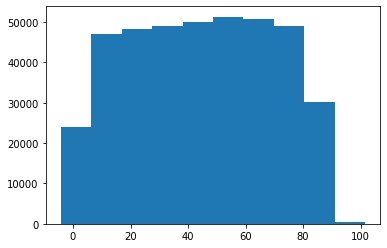

In [10]:
E_mypreds = mypreds*target_stdevs[8] + target_means[8]
_ = plt.hist(E_mypreds)

In [11]:
np.save("predictions.npy",E_mypreds)